In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"#&release=2021-07-06"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-08-16


In [41]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-03-01"},    
    {"start":"2021-03-01", "end":top_date},
    {"start":"2021-01-01", "end":top_date}
]

wave = 3
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[ 5890  5683  5097  4790  4551  3701  3541  5566  5213  5010  4687  4613
  3449  3583  5437  4740  4850  4520  4139  3366  4517  5146  4337  5104
  4447  3622  2940  4096  3198  2953  3140  2867  2129  2014  1925  2189
  2562  2586  2480  2314  1887  1897  2234  1909  1937  1801  1806  1308
  2133  2128  1940  2124  1883  1577  1205  1774  2088  1694  2019  1764
  1409  1126  1214  1694  2038  2037  1800  1557  1202  1846  2170  1743
  1767  1653  1457  1260  1521  2242  2141  2172  1912  1799  1533  1842
  2616  2688  3068  2961  2827  2394  2533  3062  4332  4920  4972  4738
  3859  4610  6593  6429  6707  6532  6337  5253  5908  8685  8857  9157
  9195  8509  6938  8006 12397 13207 14393 14704 14507 13172 15038 22874
 22673 23403 23605 21723 20195 21313 29501 30942 33497 29262 28438 24893
 26912 39591 42281 49214 56286 50070 34601 32447 42370 35066 30964 27040
 23931 19793 19181 25808 25331 26228 24704 21528 17957 18152 25877 26332
 28131 27436 24233 19451 19615 27534 26849 28350 26

In [42]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [43]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

cases_admiss_outputs = []

In [44]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 2000, verbose=True, n_processes=10)
    cases_admiss_outputs.append(pos)
cases_admiss_outputs = np.array(cases_admiss_outputs)

2021-08-18 19:26:36,296 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=39.3
2021-08-18 19:26:46,553 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39.34132644621935, best pos: [ 1.90512192e-03  1.28505890e-03  5.35802836e-04  6.09550485e-04
  7.79975932e-04  1.19858088e-03  3.07812784e-03  2.46862898e-03
  6.59986733e-04  2.07662419e-05  1.57265575e-03  5.35886910e-04
  7.80781148e-04  1.24245080e-03  1.05882026e-03  6.48437028e-04
 -2.23177749e-04 -2.07652089e-05  2.10753399e-04 -1.13397830e-04
  1.01502406e-03  9.28170223e-05  4.60603874e-04  8.05464678e-04
  7.02047279e-05 -5.81159843e-05  1.69345568e-04  7.69591791e-04
  1.76641273e-03  2.12148435e-03]
2021-08-18 19:26:46,560 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_co

pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=40.9
2021-08-18 19:28:27,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 40.93849303546005, best pos: [ 2.28318588e-03  4.80729429e-04  6.45696923e-04  9.27956429e-04
  6.27136864e-04  9.93905548e-04  3.43081971e-03  2.35011032e-03
  1.24586951e-03  3.94251898e-04  2.31711094e-04  6.90670323e-04
  5.51962764e-04  1.20425450e-03  5.59459788e-04  6.27446376e-04
  5.38402756e-04 -4.08874517e-05  7.24732776e-04  5.54000968e-04
  3.98638442e-04 -2.07148496e-05  3.14658753e-04  7.21039430e-04
  4.53267305e-04 -8.51310461e-06 -7.29776658e-05  1.21179501e-03
  2.50203295e-03  9.07748344e-04]
2021-08-18 19:28:27,039 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=41.5
2021-08-18 19:28:37,345 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 41.48194631630108, 

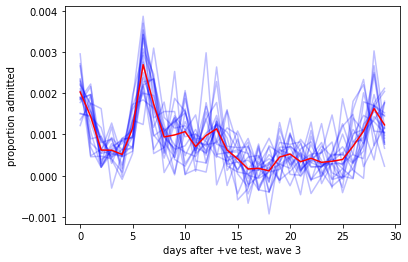

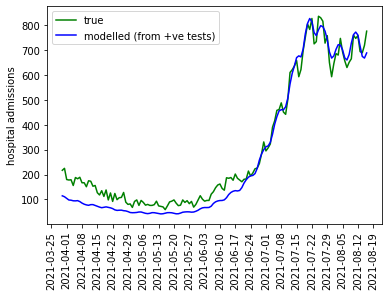

In [56]:
plt.clf()
x = list(range(len(pos)))
for y in cases_admiss_outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg_cases_admiss = []
for i in range(len(y)):
    y_avg_cases_admiss.append(np.mean(cases_admiss_outputs[:,i]))
plt.plot(x, y_avg_cases_admiss, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(y_avg_cases_admiss, cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


cases_admiss[wave] = y_avg_cases_admiss

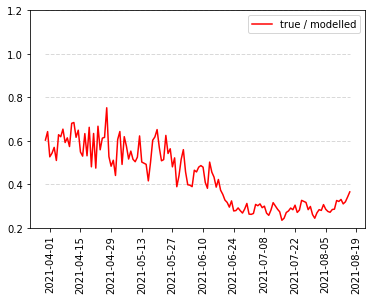

[0.60340718 0.64237299 0.52642285 0.54295281 0.56977479 0.50966237
 0.62807535 0.61884284 0.6536982  0.59213613 0.61357179 0.57368683
 0.68048971 0.68425063 0.61612947 0.64883703 0.54863835 0.52956989
 0.63324812 0.53115158 0.66219539 0.48045869 0.63384411 0.47449691
 0.66721463 0.55881121 0.61241801 0.61579994 0.75197593 0.5274435
 0.48324794 0.5107077  0.44060679 0.60605437 0.64278718 0.49146727
 0.619057   0.57501152 0.51631207 0.55275869 0.5149384  0.50388423
 0.52491537 0.62258336 0.50239039 0.49701354 0.49185846 0.41581061
 0.50104562 0.60275733 0.61792669 0.65173206 0.56993785 0.50819661
 0.51352374 0.62492151 0.54181642 0.56343089 0.48034954 0.52160885
 0.38884693 0.43961712 0.51491913 0.55944415 0.45718885 0.39809836
 0.39591791 0.38921069 0.46495247 0.45689886 0.47892404 0.48614845
 0.47880363 0.40883467 0.38171439 0.50217509 0.45586526 0.43318633
 0.38700679 0.4221184  0.37311799 0.35379386 0.32736934 0.31667514
 0.29510613 0.32371597 0.27737289 0.27938107 0.29137068 0.27859

In [46]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.ylim(0.2,1.2)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print((true/pred))

2 0.08520216951520246 (10.710075255102574,)
4 0.07358290797278642 (11.743353021570506,)
3 0.02558179874996956 (12.312094202302886,)


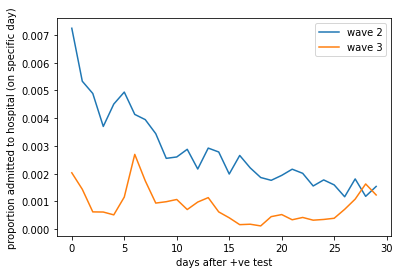

In [47]:
for wave,y_avg_cases_admiss in cases_admiss.items():
    print(wave, np.sum(y_avg_cases_admiss), center_of_mass(np.array(y_avg_cases_admiss)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_cases_admiss in cases_admiss.items():
    if (wave==4):
        continue
    plt.plot(x, y_avg_cases_admiss, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()
#print(list(zip(x,y_avg_cases_admiss)))

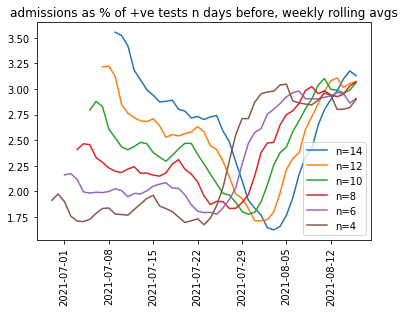

In [29]:
x_dateTimes = df.dateTime.to_list()[-len(x)-30:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [12]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(x)) if np.sum(x)>1 else 0
    return ret    

print(_g(np.array([0.5,0.6]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1.7, 1.7, 3.9, 5.1, 5.1]))


In [49]:
n_dim = 30
n_particles = 1000

x_max = 0.25*np.ones(n_dim)
x_min = -0.05*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

admiss_occup_outputs = []

In [50]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    admiss_occup_outputs.append(pos)
admiss_occup_outputs = np.array(admiss_occup_outputs)

2021-08-18 19:37:16,813 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=498  
2021-08-18 19:37:24,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 497.8566445829536, best pos: [ 0.12315148  0.05138101  0.06801246  0.09086718 -0.00374419  0.10452169
  0.07783079 -0.0020473   0.1217026   0.05250387  0.00676706  0.0388399
 -0.03533687  0.02721588  0.09937667  0.03725838 -0.03293095  0.02574026
  0.01065553  0.01723992 -0.00385055  0.0106002  -0.02989055  0.00086216
 -0.01378254 -0.00323238  0.02137607  0.0507737   0.00702203  0.06632945]
2021-08-18 19:37:24,601 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=487  
2021-08-18 19:37:32,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 486.8617292789

2021-08-18 19:38:50,029 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=496  
2021-08-18 19:38:57,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 496.0842768672584, best pos: [ 0.09983081  0.10536966  0.08628904 -0.01645784  0.0319893   0.07884757
  0.00148625  0.15064892  0.10781716  0.07542998  0.07698202 -0.00028981
 -0.01696108 -0.01185719 -0.01421061  0.06502211 -0.03006009  0.01277698
  0.04834115 -0.03315308 -0.00539914  0.037722    0.03576955  0.00932662
  0.02150262  0.01720132 -0.02357777 -0.03017902  0.02821391  0.0790014 ]
2021-08-18 19:38:57,798 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=496  
2021-08-18 19:39:05,668 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 495.953485552

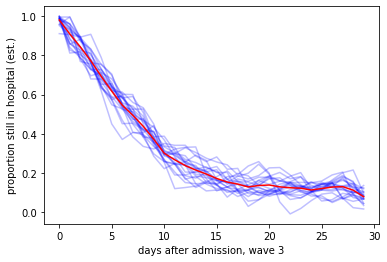

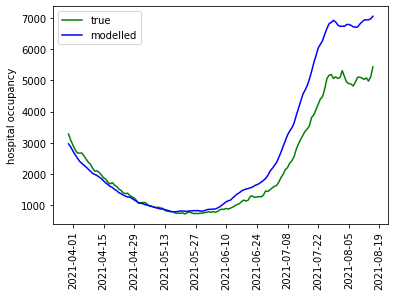

In [51]:
plt.clf()
x = list(range(len(pos)))
for y in admiss_occup_outputs:
    plt.plot(x, cumsumflip(y), color="blue", alpha=0.25)
y_avg_admiss_occup = []
for i in range(len(y)):
    y_avg_admiss_occup.append(np.mean(admiss_occup_outputs[:,i]))
plt.plot(x, cumsumflip(y_avg_admiss_occup), color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital (est.)")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg_admiss_occup), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg_admiss_occup

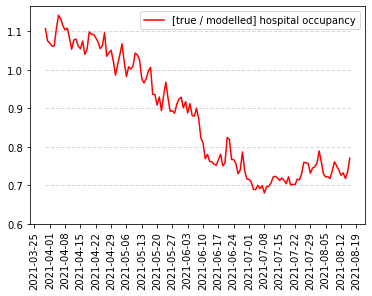

In [52]:
plt.clf()
true, pred = _g(y_avg_admiss_occup, admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

2 0.9727985781196706 (9.088321753621717,)
4 0.9727985781196706 (9.088321753621717,)
3 0.9808189977703656 (8.994749167895138,)


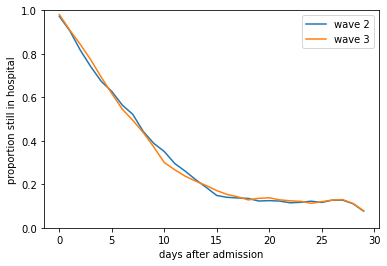

In [55]:
for wave,y_avg_admiss_occup in admiss_occup.items():
    print(wave, np.sum(y_avg_admiss_occup), center_of_mass(np.array(y_avg_admiss_occup)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_admiss_occup in admiss_occup.items():
    if wave==4:
        continue
    plt.plot(x, cumsumflip(y_avg_admiss_occup), label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.ylim(0,1)
plt.show()
#print(list(zip(x,y_avg_admiss_occup)))